In [175]:
# !pip install qiskit
# !pip install numpy
# !pip install matplotlib
# !pip install fractions
# !pip install --upgrade qiskit

In [176]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from math import gcd
from fractions import Fraction
import numpy as np

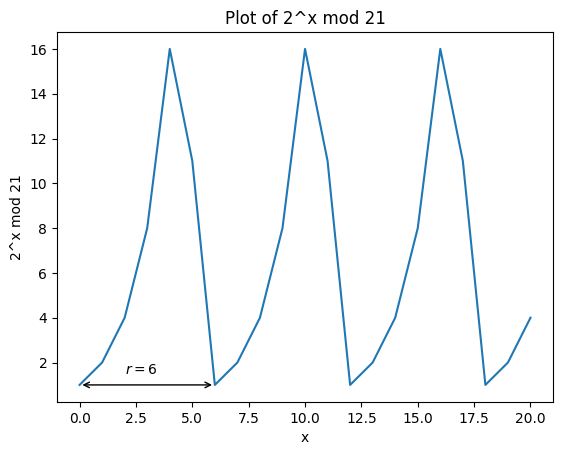

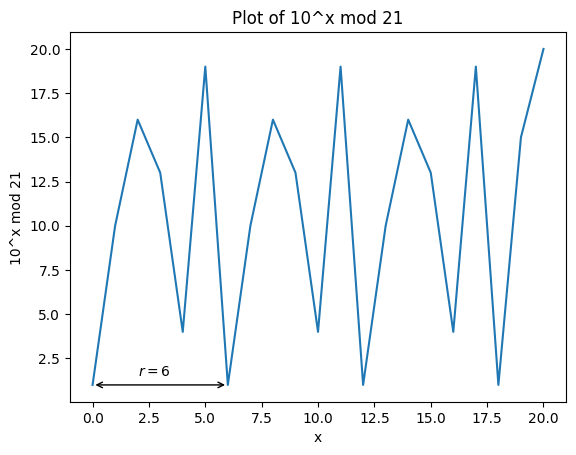

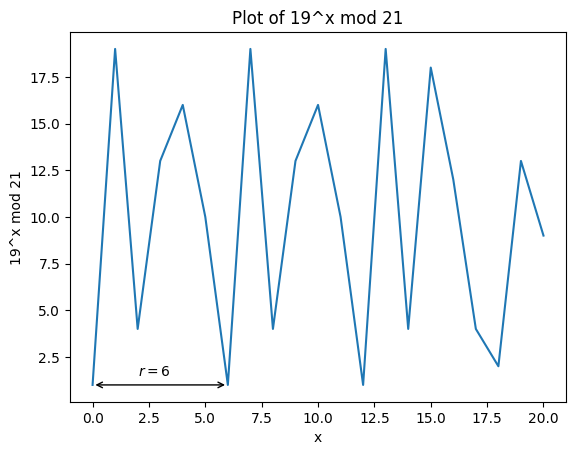

In [177]:
import matplotlib.pyplot as plt
import numpy as np

N_value = 21
a = [2, 10, 19] # 4, 10, 19 values chosen for the project

for i in range(len(a)):
    xval = np.arange(N_value)
    yvals = [np.mod(a[i]**x, N_value) for x in xval]

    fig, ax = plt.subplots()
    ax.plot(xval, yvals, label=f'a = {a[i]}')
    ax.set_xlabel('x')
    ax.set_ylabel(f'{a[i]}^x mod {N_value}')
    ax.set_title(f'Plot of {a[i]}^x mod {N_value}')

    try:
        r = yvals[1:].index(1) + 1
        plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
        plt.annotate(f'$r={r}$', xy=(r/3,1.5))
    except ValueError:
        print('Could not find period, check a < N and have no common factors.')


As we saw above, for N = 21 we obtain a period r = 6. 


Now knowing 3 a values and r, we have to build the swap circuit that maps every controlled moltiplication in the correct result, So i have to build a function named c_amod21 that receives as input power and a and outputs the corrected circuit for this operation  

to find the cicles inside |a*y mod N > i used a small function for each given a

In [178]:
# Estraiamo i cicli di permutazione per la funzione y -> 4*y mod 21, ignorando y=0
cycles = []

cycles_dict = {
    2: [],
    10: [],
    19: []
}
for i in range(len(a)):
    mapping = {y: (a[i] * y) % N_value for y in range(0, N_value)} 
    visited = set()

    for y in mapping:
        if y not in visited:
            cycle = []
            current = y
            while current not in visited:
                visited.add(current)
                cycle.append(current)
                current = mapping[current]
            if len(cycle) > 1:
                cycles_dict[a[i]].append(cycle)

# for i in range(len(a)):
#     mapping = {y: (a[i] * y) % N_value for y in range(0, N_value)} 
#     visited = set()

#     for y in mapping:
#         if y not in visited:
#             cycle = []
#             current = y
#             while current not in visited:
#                 visited.add(current)
#                 cycle.append(current)
#                 current = mapping[current]
#             if len(cycle) > 1:
#                 cycles.append(cycle)
#     print(f'Cycles for a = {a[i]}: {cycles}')
#     cycles.clear()

In [179]:
from qiskit import QuantumCircuit

def c_amod21(a, power):
    """Controlled multiplication by a mod 21 for a in {4, 10, 19}."""
    # Precomputed cycle decomposition for multiplication by a mod 21
    if a not in cycles_dict:
        raise ValueError("This implementation only supports a = 4, 10, or 19.")

    cycles = cycles_dict[a]
    U = QuantumCircuit(5)

    # For each power, apply the cycle decomposition
    for _ in range(power):
        for cycle in cycles:
            # Decompose a k-cycle (x0, x1, ..., x_{k-1}) into transpositions
            x0 = cycle[0]
            for xi in reversed(cycle[1:]):
                # Determine which qubit wires differ between state x0 and xi
                diff_bits = [bit for bit in range(5)
                             if ((x0 >> bit) & 1) != ((xi >> bit) & 1)]
                if len(diff_bits) == 1:
                    # Single-bit difference: apply X
                    U.x(diff_bits[0])
                elif len(diff_bits) == 2:
                    # Two-bit difference: swap those wires
                    U.swap(diff_bits[0], diff_bits[1])
                else:
                    # Multi-bit difference: flip all then swap adjacent
                    for b in diff_bits:
                        U.x(b)
                    for i in range(len(diff_bits) - 1):
                        U.swap(diff_bits[i], diff_bits[i+1])
                    # Restore any extra flips
                    for b in diff_bits:
                        U.x(b)

    # Convert to a gate and add control
    gate = U.to_gate()
    gate.name = f"{a}^{power} mod 21"
    return gate.control()


To complete the Shor algorithm, it's necessary the implementation of the QFT dagger, to convert the phase register value from the frequency domain to the real domain and so obtain the r value, fondamental to discover the factorization values of N = 21. 

In [180]:

def qft_dagger(n):
    """n-qubit QFTdagger"""
    qc = QuantumCircuit(n)
    for i in range(n//2):
        qc.swap(i, n-i-1)
    for i in range(n):
        for j in range(i):
            qc.cp( -np.pi / 2**(i-j), i, j)
        qc.h(i)
    qc.name = "QFT"
    return qc

now, lets build the circuit, knowing that for N=21 we require 5 qubits, for the phase register i'll choose to represent it on 8 qubits.

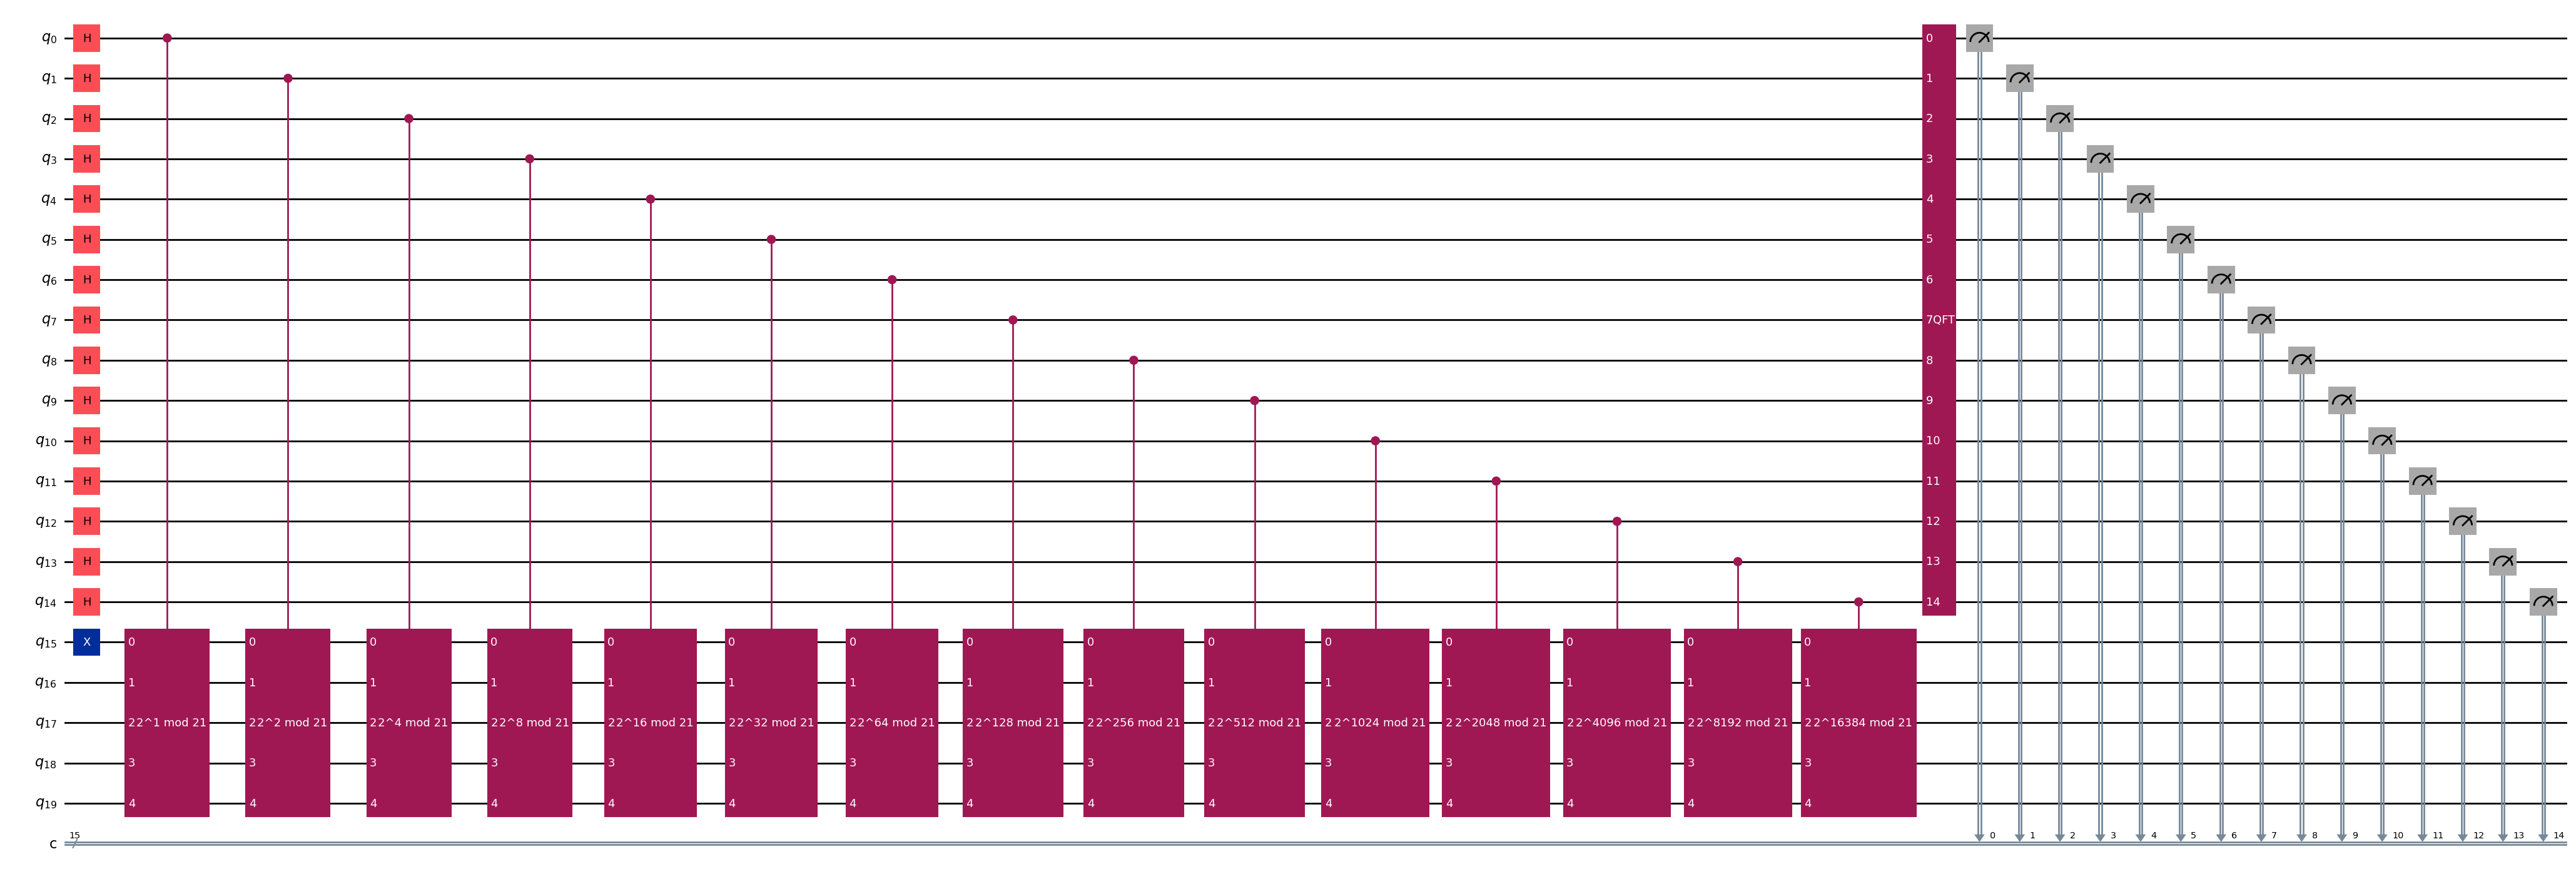

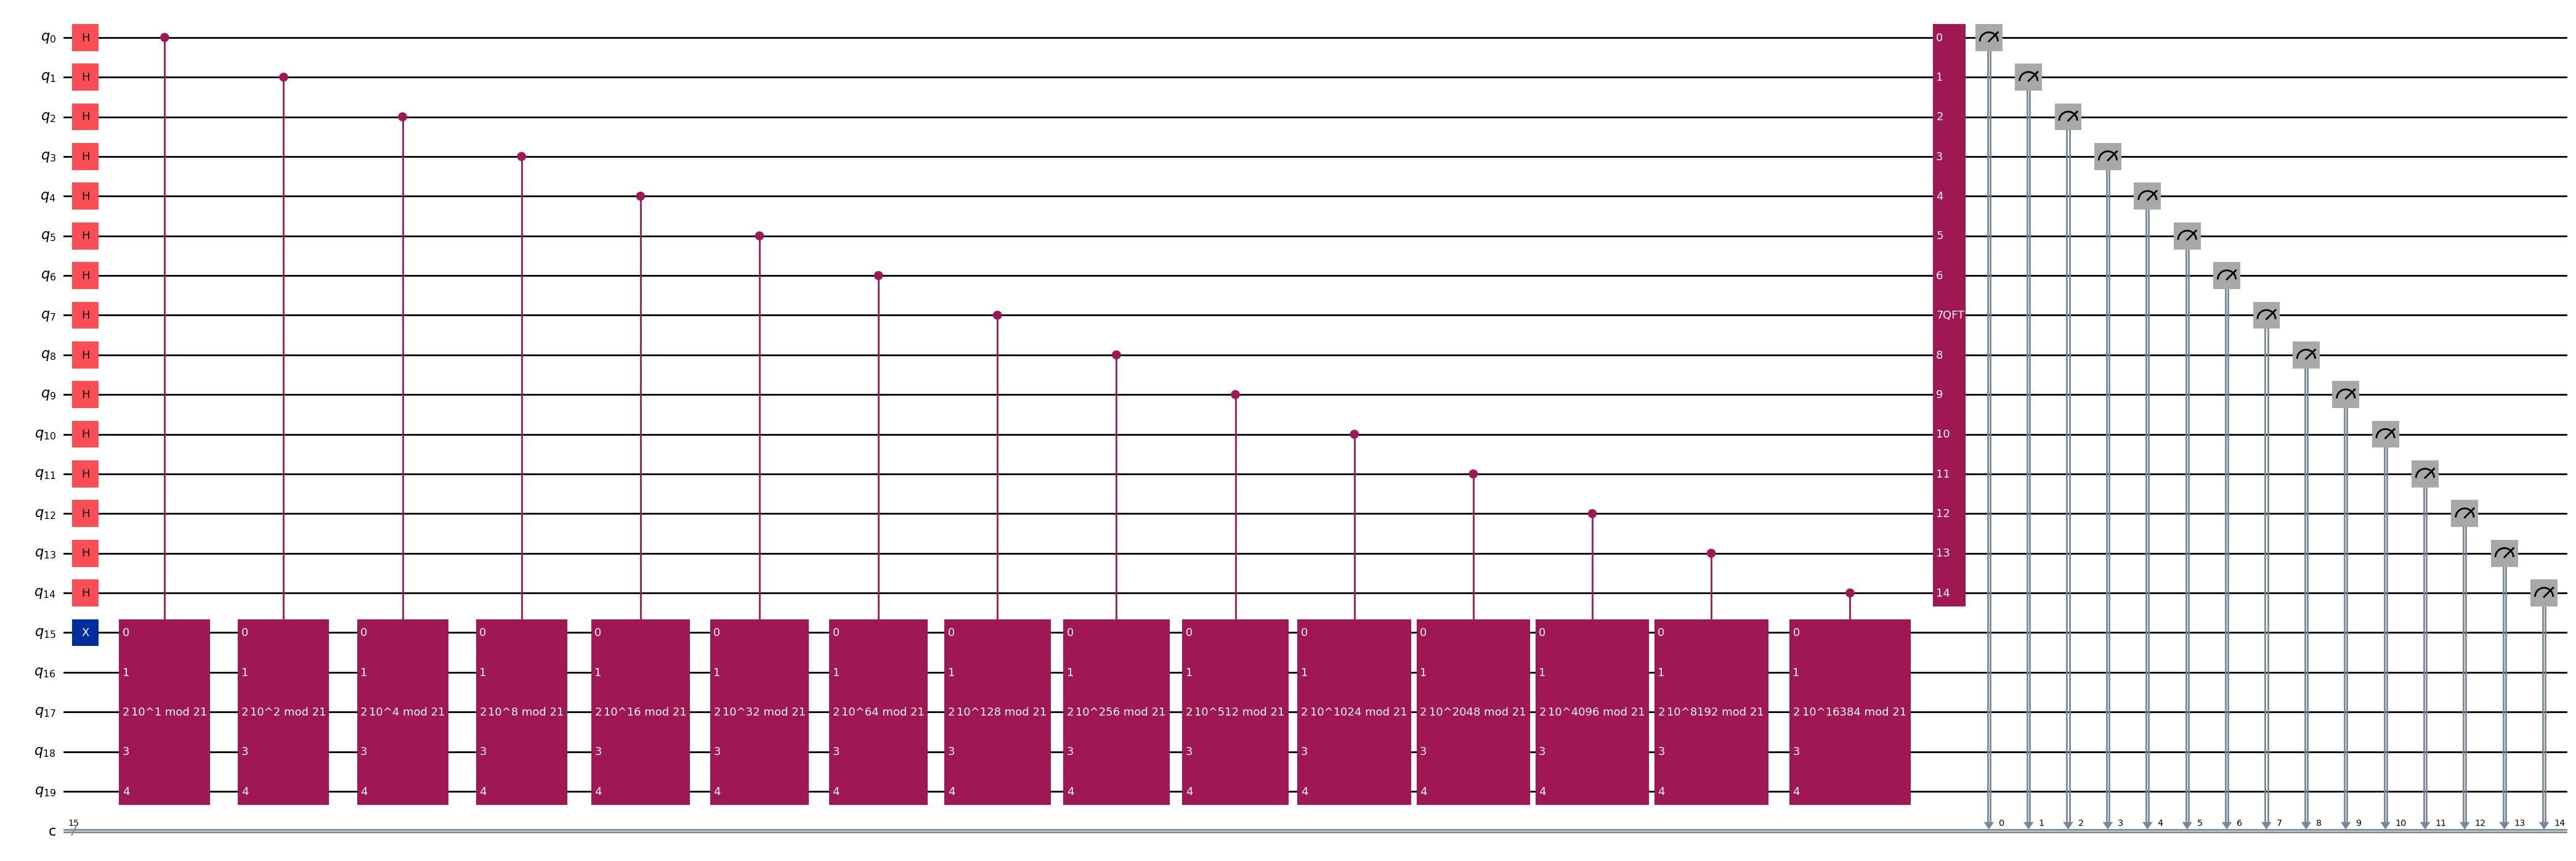

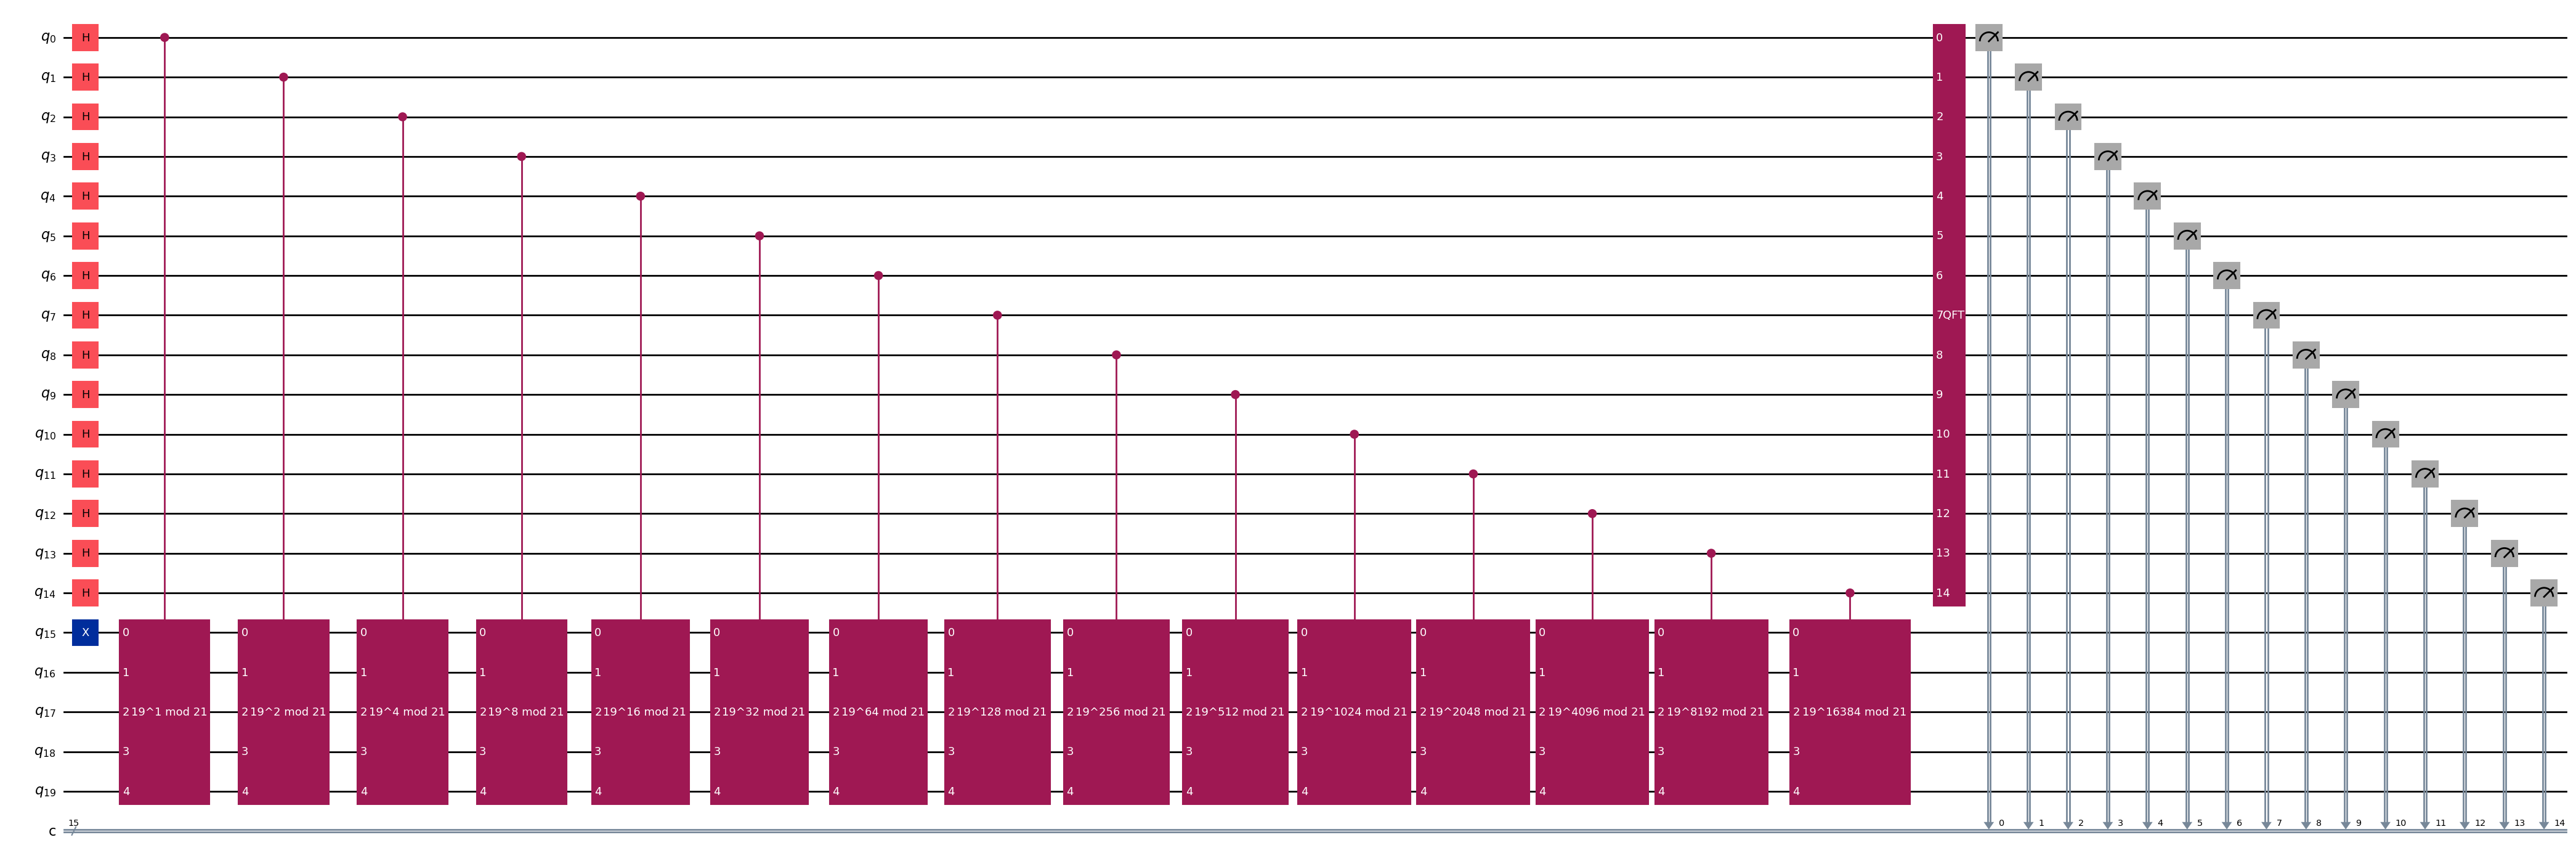

In [181]:
from IPython.display import display

N_COUNT = 15

for i in a:
    qc = QuantumCircuit(N_COUNT + 5, N_COUNT)

    # init counting register in |+>
    for q in range(N_COUNT):
        qc.h(q)
    # init aux register in |1>
    qc.x(N_COUNT)

    aux = list(range(N_COUNT, N_COUNT+5))
    for ii in range(N_COUNT):
        qc.append(c_amod21(i, 2**ii), [ii] + aux)

    # inverse QFT + measure
    qc.append(qft_dagger(N_COUNT), range(N_COUNT))
    qc.measure(range(N_COUNT), range(N_COUNT))

    # show each single circuit
    fig = qc.draw(output='mpl', fold=-1)
    display(fig)


In [182]:
from qiskit_aer import AerSimulator

In [183]:
backend = AerSimulator()

# Per usare un vero backend IBM Quantum, decommenta e inserisci il tuo token:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<IL_TUO_TOKEN>")
# real_backend = service.least_busy(simulator=False, operational=True)

def run_circuit(circuit, backend):
    """Run the quantum circuit on the specified backend."""
    # Circuits must obey the ISA of the backend.
    # Convert to ISA circuits
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime import SamplerV2 as Sampler

    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(circuit)

    sampler = Sampler(mode=backend)  # our Primitive
 
    job = sampler.run([isa_circuit])  # parameter is a list of PUBs

    return job
    

def get_counts(job):
    result = job.result()
    counts = result[0].data.c.get_counts()
    return counts


In [184]:
def deduce_factors(a, N, counts):
    """Deduce factors of N from the measurement results."""
    # Extract the most frequent result
    measured = max(counts, key=counts.get)
    phase = int(measured, 2) / (2**len(measured))
    
    # Use the phase to calculate the period
    r = Fraction(phase).limit_denominator(N).denominator
    print(f"Estimated period r: {r}")
    
    # Compute the factors
    if r % 2 != 0 or pow(a, r // 2, N) == -1 % N:
        print("Period invalid, retrying...")
        return None, None
    
    factor1 = gcd(pow(a, r // 2) - 1, N)
    factor2 = gcd(pow(a, r // 2) + 1, N)
    return factor1, factor2


In [ ]:
job = run_circuit(qc, backend)
counts = get_counts(job)
plot_histogram(counts)

In [ ]:
import pandas as pd
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

             Register Output           Phase
0   00000000(bin) =   0(dec)    0/256 = 0.00
1   01010101(bin) =  85(dec)   85/256 = 0.33
2   10101011(bin) = 171(dec)  171/256 = 0.67
3   01010110(bin) =  86(dec)   86/256 = 0.34
4   10101110(bin) = 174(dec)  174/256 = 0.68
5   10101010(bin) = 170(dec)  170/256 = 0.66
6   10101101(bin) = 173(dec)  173/256 = 0.68
7   10101001(bin) = 169(dec)  169/256 = 0.66
8   10101100(bin) = 172(dec)  172/256 = 0.67
9   01011001(bin) =  89(dec)   89/256 = 0.35
10  01111101(bin) = 125(dec)  125/256 = 0.49
11  01010111(bin) =  87(dec)   87/256 = 0.34
12  01010100(bin) =  84(dec)   84/256 = 0.33
13  01010011(bin) =  83(dec)   83/256 = 0.32
14  10000010(bin) = 130(dec)  130/256 = 0.51
15  01010000(bin) =  80(dec)   80/256 = 0.31
16  01011000(bin) =  88(dec)   88/256 = 0.34
17  11110110(bin) = 246(dec)  246/256 = 0.96
18  10001100(bin) = 140(dec)  140/256 = 0.55
19  01001100(bin) =  76(dec)   76/256 = 0.30
20  01010001(bin) =  81(dec)   81/256 = 0.32
21  101101

In [ ]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(21)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

       Phase Fraction  Guess for r
0   0.000000      0/1            1
1   0.332031      1/3            3
2   0.667969      2/3            3
3   0.335938      1/3            3
4   0.679688    13/19           19
5   0.664062      2/3            3
6   0.675781    13/19           19
7   0.660156      2/3            3
8   0.671875      2/3            3
9   0.347656     7/20           20
10  0.488281      1/2            2
11  0.339844      1/3            3
12  0.328125      1/3            3
13  0.324219     6/19           19
14  0.507812      1/2            2
15  0.312500     5/16           16
16  0.343750     7/20           20
17  0.960938    20/21           21
18  0.546875     6/11           11
19  0.296875     5/17           17
20  0.316406     6/19           19
21  0.710938      5/7            7
22  0.152344     2/13           13
23  0.683594    13/19           19
24  0.656250    13/20           20
25  0.320312     6/19           19
26  0.687500    11/16           16
27  0.351562     6/1

In [ ]:
r=6
guesses = [gcd(a[0]**(r//2)-1, 21), gcd(a[0]**(r//2)+1, 21)]
print(guesses)

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'